In [2]:
%load_ext autoreload
%autoreload 2

import sys
if sys.path[-1] != "..": sys.path.append("..")

from qBN.qBNMC import qBayesNet
from qBN.qBNRejection import qInference
from qBN.qBNRT import qRuntime

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33'
)

backend = service.get_backend("ibm_brisbane")

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33')

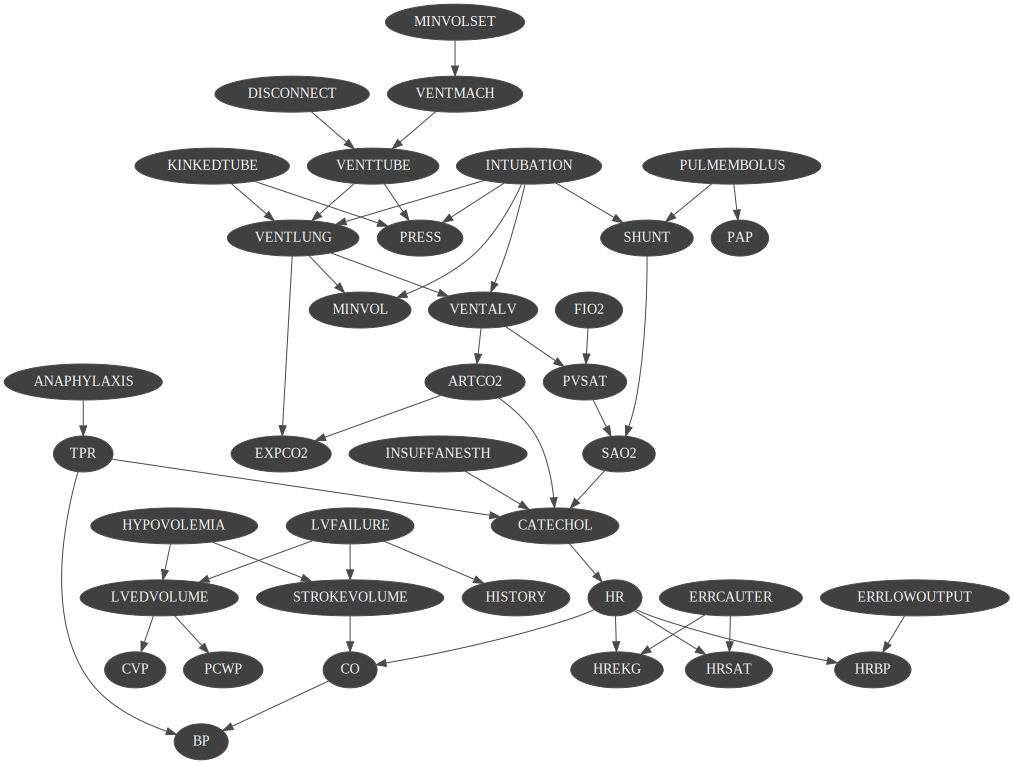

In [4]:
bn = gum.loadBN("alarm.dsl")
gnb.showBN(bn, size = 20)

In [5]:
qbn = qBayesNet(bn)
qc = qbn.buildCircuit(add_measure=True)

In [6]:
evidence = {"MINVOLSET": 0, "DISCONNECT": 0}
ie = gum.LazyPropagation(bn)
ie.setEvidence(evidence)
ie.makeInference()
print(f"Evidence: {evidence}")
print(f"Evidence probability: {ie.evidenceProbability()}")

Evidence: {'MINVOLSET': 0, 'DISCONNECT': 0}
Evidence probability: 0.004999999805722265


In [7]:
target_node = "VENTTUBE"

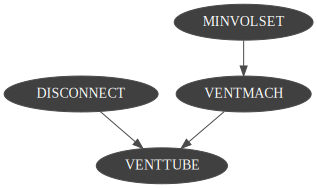

In [8]:
qinf = qInference(qbn)
qinf.setEvidence(evidence)
qinf.setMaxIter(1000)
qinf.useFragmentBN(target={target_node})
gnb.showBN(qinf.qbn.bn, size=20)

In [9]:
qinf.getGates()

In [10]:
qinf.makeInference()

{'VENTMACH': [0.06100000000000005, 0.9240000000000007, 0.007, 0.008],
 'DISCONNECT': [1.0000000000000007, 0],
 'MINVOLSET': [1.0000000000000007, 0, 0],
 'VENTTUBE': [0.9670000000000007,
  0.006,
  0.016000000000000007,
  0.011000000000000003]}

In [11]:
gnb.sideBySide(qinf.posterior(target_node),
               ie.posterior(target_node),
               captions=["qInference", "LazyPropagation"])

In [15]:
mc = gum.MonteCarloSampling(bn)
mc.setEvidence(evidence)
mc.setMaxIter(10000)
mc.makeInference()

In [30]:
r = mc.posterior(target_node).toarray() - ie.posterior(target_node).toarray()

In [32]:
r.max()

0.003758412832682745

In [22]:
r.max()

0.003758412832682745

In [17]:
mc.messageApproximationScheme()

'stopped with max iteration=10000'